In [2]:
from os import getcwd
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
work_dir = getcwd()
data_dir = join(work_dir, "data")
image_dir = join(work_dir, "images")

In [4]:
ip_country = pd.read_csv(join(data_dir, "IpAddress_to_Country.csv"))
#fraud_data = pd.read_csv(join(data_dir, "Fraud_Data.csv"))
# fichier déjà pré-traité (datetime, ip_address, country)
fraud_data = pd.read_csv(join(data_dir, "fraud_data_country.csv"), index_col=0) 

In [5]:
print(f"{ip_country.shape = }, {fraud_data.shape = }")

ip_country.shape = (138846, 3), fraud_data.shape = (151112, 12)


### Exploration ip_country

In [6]:
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
ip_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [8]:
ip_country.nunique()

lower_bound_ip_address    138846
upper_bound_ip_address    138846
country                      235
dtype: int64

In [9]:
# conversion de lower_bound_ip_address en int
ip_country["lower_bound_ip_address"] = ip_country["lower_bound_ip_address"].astype("int64")

In [10]:
ip_country[["lower_bound_ip_address"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 1 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   lower_bound_ip_address  138846 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


In [11]:
ip_country.query("country == 'China'").tail(10)

,lower_bound_ip_address,upper_bound_ip_address,country
138815,3755737088,3755868159,China
138822,3755978752,3755982847,China
138823,3755982848,3755986943,China
138829,3757047808,3757572095,China
138830,3757572096,3757834239,China
138832,3757867008,3757899775,China
138834,3757965312,3758030847,China
138835,3758030848,3758063615,China
138840,3758091264,3758092287,China
138843,3758095360,3758095871,China


### Exploration fraud_data

In [12]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States


In [13]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         151112 non-null  int64 
 1   signup_time     151112 non-null  object
 2   purchase_time   151112 non-null  object
 3   purchase_value  151112 non-null  int64 
 4   device_id       151112 non-null  object
 5   source          151112 non-null  object
 6   browser         151112 non-null  object
 7   sex             151112 non-null  object
 8   age             151112 non-null  int64 
 9   ip_address      151112 non-null  int64 
 10  class           151112 non-null  int64 
 11  country         151112 non-null  object
dtypes: int64(5), object(7)
memory usage: 15.0+ MB


### conversion de ip_address en int

In [14]:
fraud_data["ip_address"] = fraud_data["ip_address"].astype("int64")

### conversion des features datetime

In [56]:
fraud_data["signup_time"] = pd.to_datetime(fraud_data["signup_time"])
fraud_data["purchase_time"] = pd.to_datetime(fraud_data["purchase_time"])

In [57]:
fraud_data[["ip_address", "signup_time", "purchase_time"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 0 to 151111
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ip_address     151112 non-null  int64         
 1   signup_time    151112 non-null  datetime64[ns]
 2   purchase_time  151112 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 8.6 MB


In [58]:
ip = fraud_data["ip_address"][0]
ip_country[(ip >= ip_country.lower_bound_ip_address) & (ip <= ip_country.upper_bound_ip_address)]["country"].iloc[0]

'Japan'

### Ajout de la colonne country à partir de l'adresse IP

In [59]:
def get_country(country_id):
    """
    Return the name of the country based on the ip address
    """
    return ip_country.iloc[int(country_id),-1]

In [60]:
# crée des bins à partir d'une des bornes ip
bins = ip_country["lower_bound_ip_address"].values

# renvoie l'id de la borne => id dans ip_country
fraud_data["country"] = pd.cut(fraud_data["ip_address"], bins, labels=False)

# map pour récupérer le country, ignorer les NaN
fraud_data["country"] = fraud_data["country"].map(get_country, na_action='ignore')

# remplacement des NaN
fraud_data["country"].fillna("unknown", inplace=True)

### Sauvegarde du fichier fraud_data_country

In [61]:
#fraud_data.to_csv(join(data_dir, "fraud_data_country.csv"))

In [62]:
fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'signup_purchase_delta'],
      dtype='object')

### user_id et device_id quasiment tous unique

In [63]:
fraud_data[["user_id", "device_id"]].nunique() / fraud_data.shape[0]

user_id      1.000000
device_id    0.912939
dtype: float64

In [64]:
time_features = [
    'signup_time',
    'purchase_time'
]

categorical = [
    'source', 
    'browser', 
    'sex',
    'country'
]

numerical = [
    'purchase_value',
    'age'
]

target = ["class"]

In [65]:
unknown_country = fraud_data[fraud_data["country"] == "unknown"]
unknown_country.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_purchase_delta
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,unknown,8201.416667
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3987484328,0,unknown,36297.083333
11,73884,2015-05-29 16:22:02,2015-06-16 05:45:58,58,ZTZZJUCRDOCJZ,Direct,Chrome,M,32,4038284553,0,unknown,25283.933333
12,79203,2015-06-16 21:19:35,2015-06-21 03:29:59,18,IBPNKSMCKUZWD,SEO,Safari,M,33,4161540926,0,unknown,6130.400000
14,82931,2015-02-16 02:50:30,2015-04-16 00:56:47,15,XKIFNYUZMBWFU,SEO,IE,M,24,4203487753,0,unknown,84846.283333


In [66]:
fraud_data[time_features + categorical].describe(include="all")

,signup_time,purchase_time,source,browser,sex,country
count,151112,151112,151112,151112,151112,151112
unique,NaN,NaN,3,5,2,182
top,NaN,NaN,SEO,Chrome,M,United States
freq,NaN,NaN,60615,61432,88293,59223
mean,2015-04-20 00:56:09.511329280,2015-06-16 02:56:38.759952896,NaN,NaN,NaN,NaN
min,2015-01-01 00:00:42,2015-01-01 00:00:44,NaN,NaN,NaN,NaN
25%,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000,NaN,NaN,NaN,NaN
50%,2015-04-19 04:41:30,2015-06-18 13:46:17.500000,NaN,NaN,NaN,NaN
75%,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000,NaN,NaN,NaN,NaN
max,2015-08-18 04:40:29,2015-12-16 02:56:05,NaN,NaN,NaN,NaN


In [67]:
fraud_data[numerical + target].describe()

,purchase_value,age,class
count,151112.000000,151112.000000,151112.000000
mean,36.935372,33.140704,0.093646
std,18.322762,8.617733,0.291336
min,9.000000,18.000000,0.000000
25%,22.000000,27.000000,0.000000
50%,35.000000,33.000000,0.000000
75%,49.000000,39.000000,0.000000
max,154.000000,76.000000,1.000000


### Distribution de la cible

In [68]:
target_ratio = [f"{r:.2%}" for r in fraud_data["class"].value_counts() / fraud_data.shape[0]]
target_ratio

['90.64%', '9.36%']

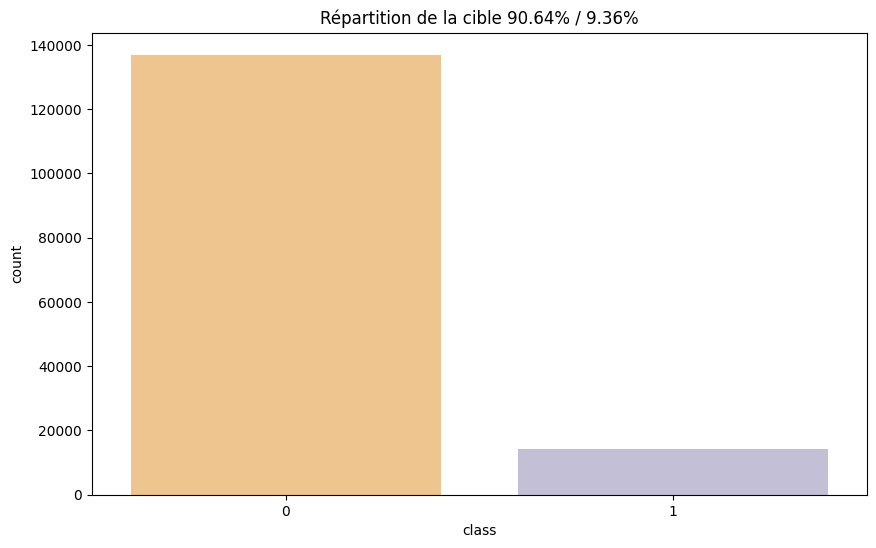

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(data=fraud_data, x="class", ax=ax, palette='PuOr', hue="class", legend=False)
ax.set_title(f"Répartition de la cible {target_ratio[0]} / {target_ratio[1]}")

plt.show()
#fig.savefig(join(image_dir, 'dist_cible.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution de l'âge

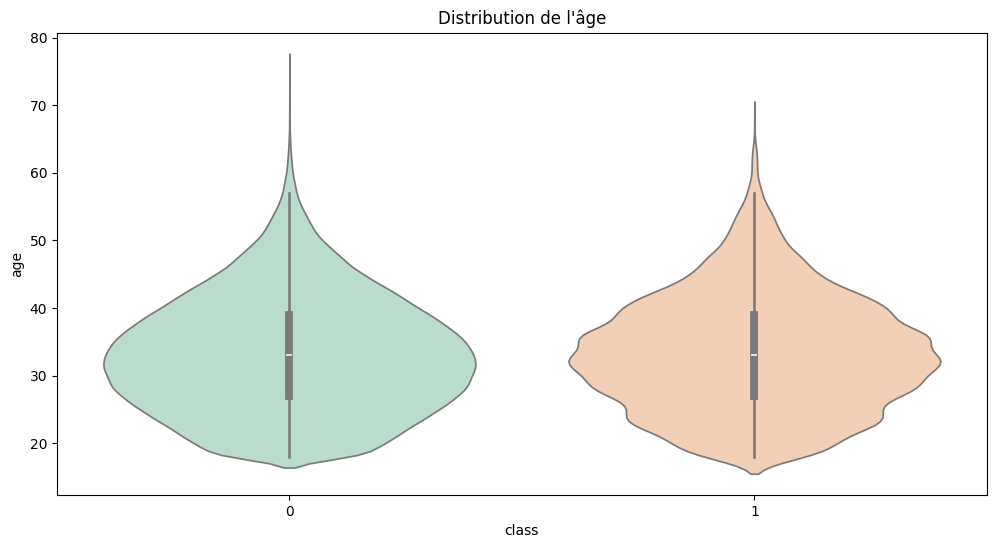

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(data=fraud_data, x="class", y="age", ax=ax, palette='Pastel2', hue="class", legend=False)
ax.set_title(f"Distribution de l'âge")

plt.show()
#fig.savefig(join(image_dir, 'dist_age.png'), transparent=False, dpi=80, bbox_inches="tight")

In [71]:
# même répartition des fraudes

borne_sup_age = fraud_data["age"].mean() + 3 * fraud_data["age"].std()
fraud_data[fraud_data["age"] > borne_sup_age]["class"].value_counts()

class
0    504
1     49
Name: count, dtype: int64

### Distribution du panier

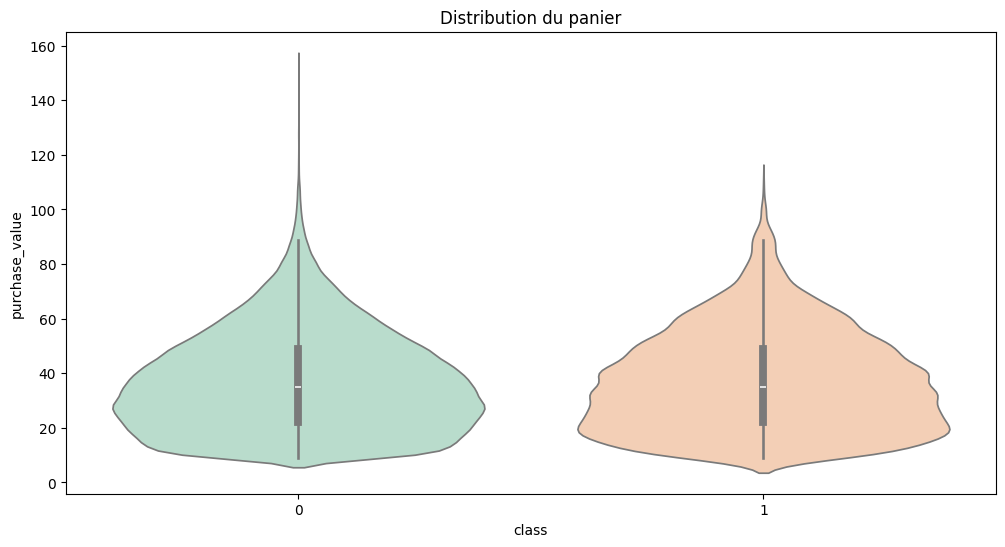

In [100]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(data=fraud_data, x="class", y="purchase_value", ax=ax, palette='Pastel2', hue="class", legend=False)
ax.set_title(f"Distribution du panier")

plt.show()
#fig.savefig(join(image_dir, 'dist_purchase.png'), transparent=False, dpi=80, bbox_inches="tight")

In [73]:
# même répartition des fraudes

borne_sup_panier = fraud_data["purchase_value"].mean() + 3 * fraud_data["purchase_value"].std()
fraud_data[fraud_data["purchase_value"] > borne_sup_panier]["class"].value_counts()

class
0    788
1     77
Name: count, dtype: int64

### Distribution du genre

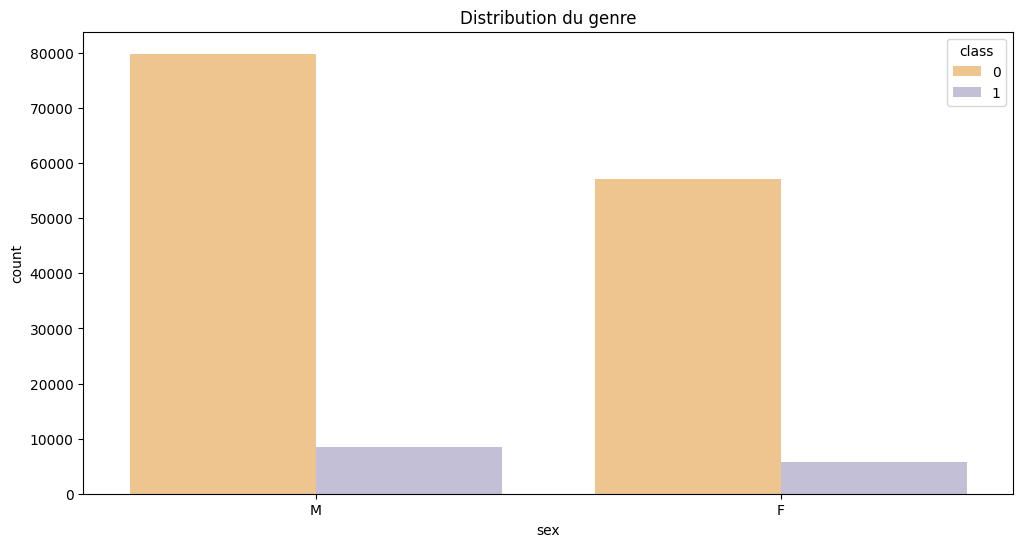

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=fraud_data, x="sex", hue="class", ax=ax, palette='PuOr')
ax.set_title(f"Distribution du genre")

plt.show()
#fig.savefig(join(image_dir, 'dist_genre.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution de la source

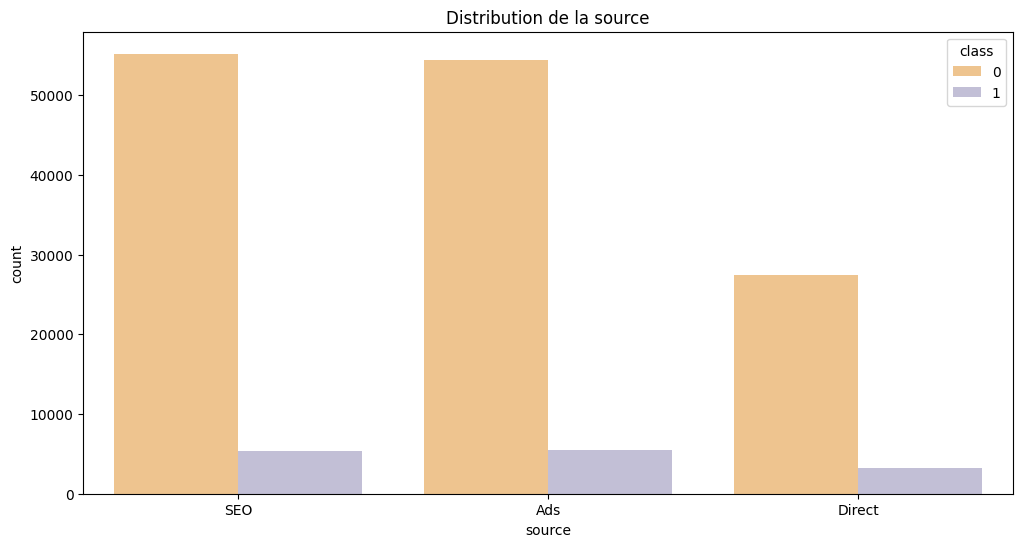

In [75]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=fraud_data, x="source", hue="class", ax=ax, palette='PuOr')
ax.set_title(f"Distribution de la source")

plt.show()
#fig.savefig(join(image_dir, 'dist_source.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution des navigateurs

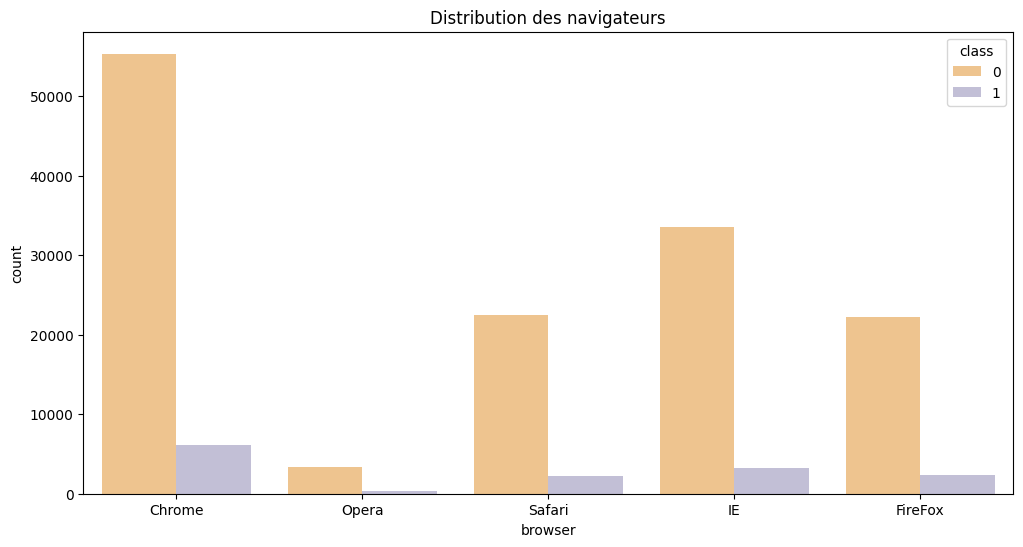

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=fraud_data, x="browser", hue="class", ax=ax, palette='PuOr')
ax.set_title(f"Distribution des navigateurs")

plt.show()
#fig.savefig(join(image_dir, 'dist_browser.png'), transparent=False, dpi=80, bbox_inches="tight")

### Répartition de la fraude par pays

In [77]:
t = 0.95
country_count = (fraud_data[fraud_data["class"] == 1]
                 .groupby("country")["class"]
                 .count()
                 .sort_values(ascending=False).reset_index())

country_count = country_count[country_count["class"] > country_count["class"].quantile(t)]
country_count["country"].values

array(['United States', 'unknown', 'China', 'Japan', 'United Kingdom',
       'Korea Republic of'], dtype=object)

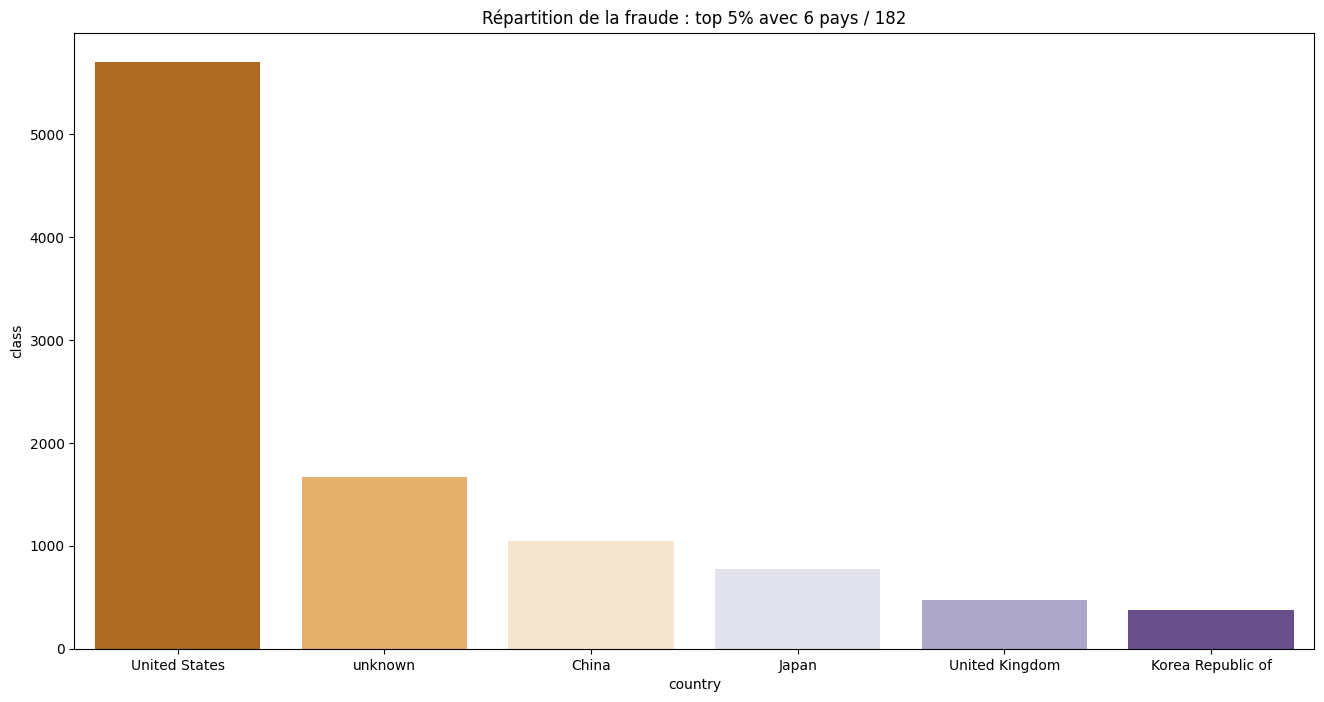

In [101]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.barplot(data=country_count, x="country", y="class", ax=ax, palette='PuOr', hue="country", legend=False)
ax.set_title(f"Répartition de la fraude : top {1-t:.0%} avec {len(country_count)} pays / {fraud_data['country'].nunique()}")

plt.show()
#fig.savefig(join(image_dir, 'dist_pays.png'), transparent=False, dpi=80, bbox_inches="tight")

### Variables de temps

In [79]:
time_features

['signup_time', 'purchase_time']

In [80]:
fraud_data[time_features].describe()

,signup_time,purchase_time
count,151112,151112
mean,2015-04-20 00:56:09.511329280,2015-06-16 02:56:38.759952896
min,2015-01-01 00:00:42,2015-01-01 00:00:44
25%,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000
50%,2015-04-19 04:41:30,2015-06-18 13:46:17.500000
75%,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000
max,2015-08-18 04:40:29,2015-12-16 02:56:05


##### données du 1er janvier au 16 décembre 2015

In [81]:
df = fraud_data.copy()

class_count_by_week = df.groupby(["class", df["purchase_time"].dt.isocalendar().week])["user_id"].count().reset_index()
class_count_by_week.columns = ["class", "week", "count"]
class_count_by_week.head()

,class,week,count
0,0,1,44
1,0,2,277
2,0,3,474
3,0,4,759
4,0,5,988


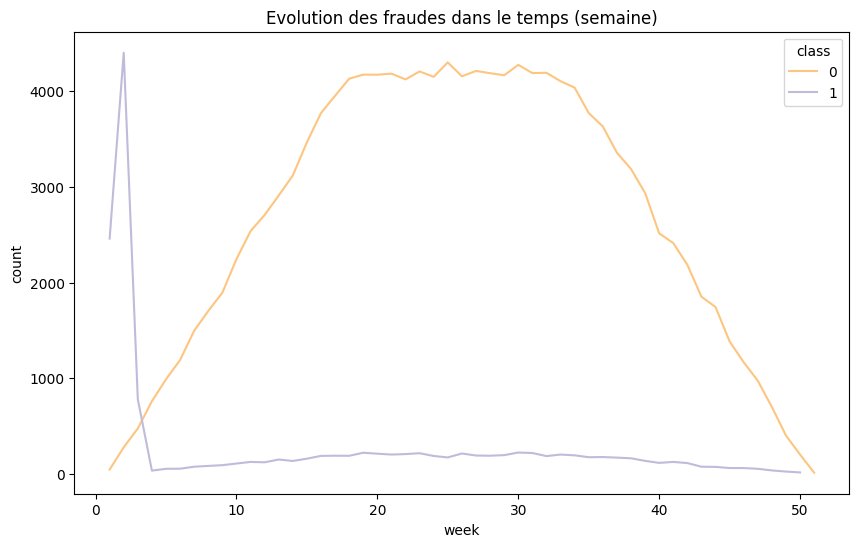

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=class_count_by_week, x="week", y="count", hue="class", ax=ax, palette='PuOr');

ax.set_title("Evolution des fraudes dans le temps (semaine)")

plt.show()
#fig.savefig(join(image_dir, 'evolution_fraude_week.png'), transparent=False, dpi=80, bbox_inches="tight")

##### pic de fraude sur les 3 premières semaines

In [83]:
class_count_by_week[class_count_by_week["class"] == 1].head()

,class,week,count
51,1,1,2460
52,1,2,4404
53,1,3,779
54,1,4,33
55,1,5,52


In [84]:
class_count_by_week[class_count_by_week["class"] == 1]["count"].mean()

283.02

### Délai entre signup et purchase en minutes

In [85]:
fraud_data["signup_purchase_delta"] = fraud_data["purchase_time"] - fraud_data["signup_time"]
numerical.append("signup_purchase_delta")

In [86]:
fraud_data["signup_purchase_delta"] = fraud_data["signup_purchase_delta"].dt.total_seconds() / 60

In [87]:
df = fraud_data.copy()

class_count_by_week = df.groupby(["class", df["purchase_time"].dt.isocalendar().week])["signup_purchase_delta"].mean().reset_index()
class_count_by_week.columns = ["class", "week", "mean_time_delta"]
class_count_by_week.head()

,class,week,mean_time_delta
0,0,1,1899.681439
1,0,2,5778.335740
2,0,3,10372.535408
3,0,4,15470.461309
4,0,5,20642.324595


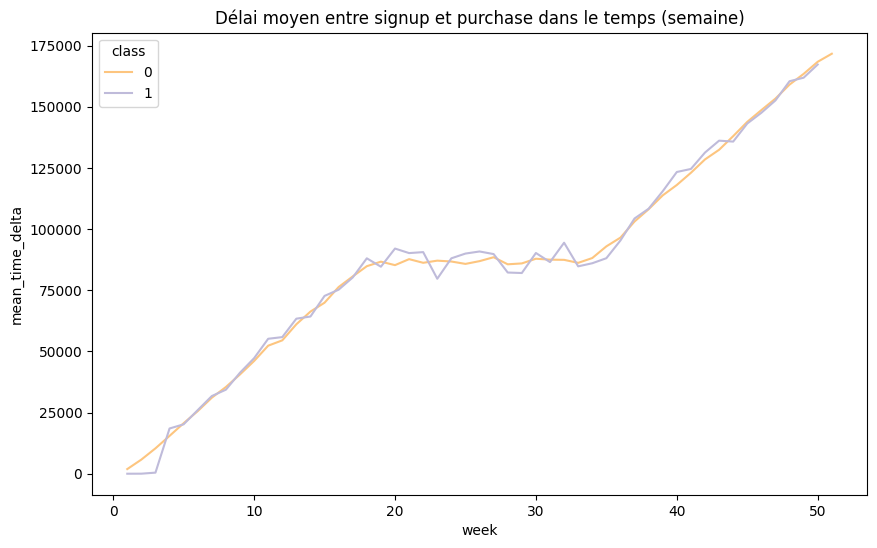

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=class_count_by_week, x="week", y="mean_time_delta", hue="class", ax=ax, palette='PuOr');

ax.set_title("Délai moyen entre signup et purchase dans le temps (semaine)")

plt.show()
#fig.savefig(join(image_dir, 'evolution_mean_time_delta_week.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution de la durée entre signup et purchase

In [89]:
display(df[df["class"] == 0]["signup_purchase_delta"].describe())

count    136961.000000
mean      86519.643149
std       49809.813488
min           2.283333
25%       43147.150000
50%       86581.850000
75%      129688.650000
max      172799.533333
Name: signup_purchase_delta, dtype: float64

In [90]:
display(df[df["class"] == 1]["signup_purchase_delta"].describe())
print("median en sec : ", df[df["class"] == 1]["signup_purchase_delta"].median() * 60)

count     14151.000000
mean      40397.372505
std       55229.813829
min           0.016667
25%           0.016667
50%           0.016667
75%       79841.841667
max      172732.450000
Name: signup_purchase_delta, dtype: float64

median en sec :  1.0


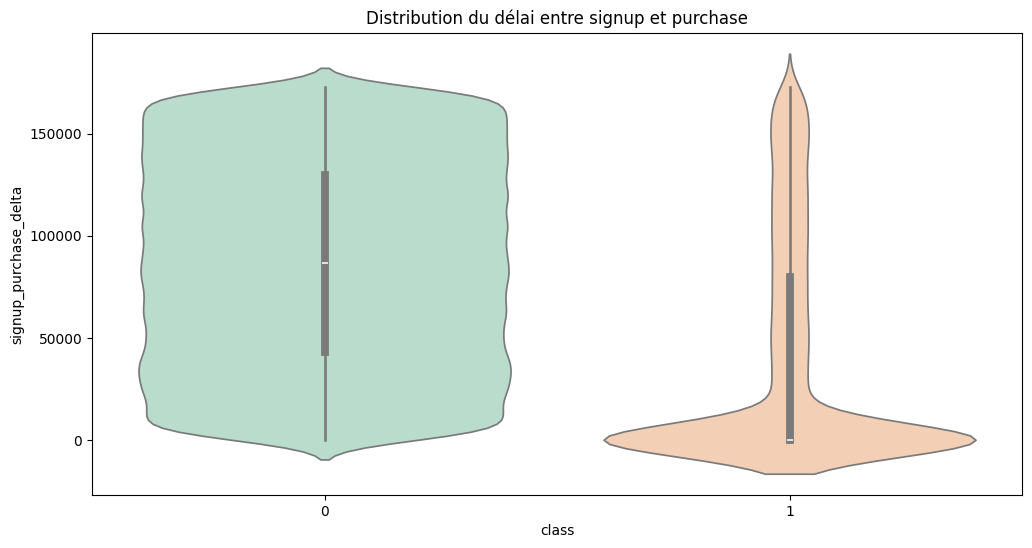

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(data=df, x="class", y="signup_purchase_delta", ax=ax, palette='Pastel2', hue="class", legend=False)
ax.set_title(f"Distribution du délai entre signup et purchase")

plt.show()
#fig.savefig(join(image_dir, 'dist_time_delta.png'), transparent=False, dpi=80, bbox_inches="tight")

In [92]:
fraud_0_delta= df[df["class"] == 0]
fraud_1_delta= df[df["class"] == 1]
med_1 = fraud_1_delta["signup_purchase_delta"].median()
std_0 = fraud_0_delta["signup_purchase_delta"].std()
std_1 = fraud_1_delta["signup_purchase_delta"].std()

fraud_0_med_1 = ((fraud_0_delta["signup_purchase_delta"] > med_1 - std_0) 
                 & (fraud_0_delta["signup_purchase_delta"] < med_1 + std_0))

fraud_1_med_1 = ((fraud_1_delta["signup_purchase_delta"] > med_1 - std_1) 
                 & (fraud_1_delta["signup_purchase_delta"] < med_1 + std_1))

display(fraud_0_delta[fraud_0_med_1]["signup_purchase_delta"].describe())

print("median en min : ", fraud_0_delta[fraud_0_med_1]["signup_purchase_delta"].median())
print(f"Pourcentage de non fraude autour du delta critique : {len(fraud_0_delta[fraud_0_med_1]) / len(fraud_0_delta):.2%}")
print(f"Pourcentage de fraude autour du delta critique : {len(fraud_1_delta[fraud_1_med_1]) / len(fraud_1_delta):.2%}")


count    39410.000000
mean     25026.414568
std      14324.114792
min          2.283333
25%      12635.141667
50%      25233.408333
75%      37365.891667
max      49807.466667
Name: signup_purchase_delta, dtype: float64

median en min :  25233.408333333333
Pourcentage de non fraude autour du delta critique : 28.77%
Pourcentage de fraude autour du delta critique : 68.45%


### Pair plot

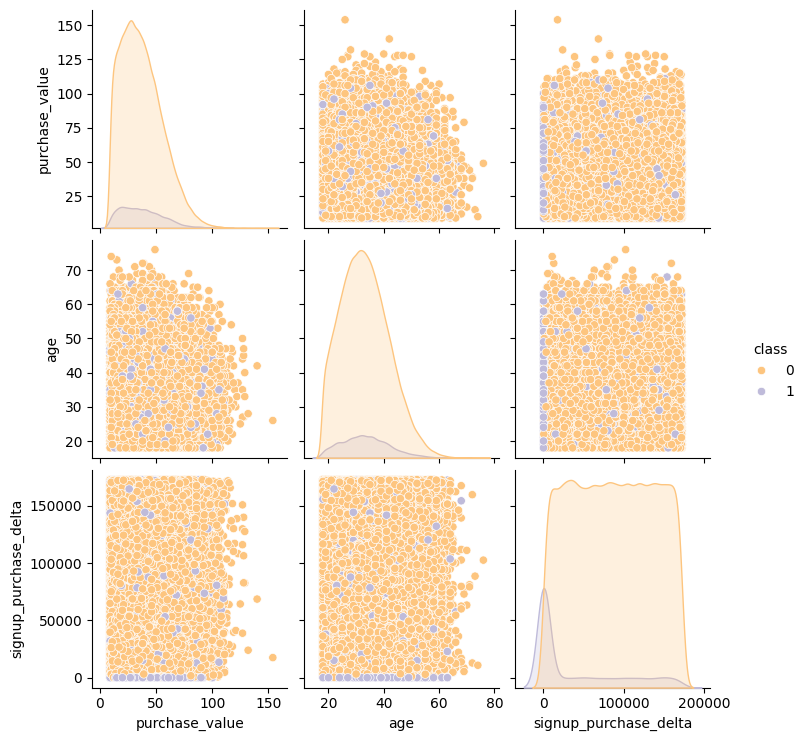

In [93]:
g = sns.pairplot(fraud_data[numerical + target], hue="class", palette='PuOr');
#g.savefig(join(image_dir, 'cat_pair_plot.png'))